In [ ]:
!pip install geemap
!pip install pyshp
!pip install PyCRS

In [ ]:
import ee
import geemap
import os

In [ ]:
def maskS2clouds(img):
    qa = img.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return img.updateMask(mask).divide(10000)

In [ ]:
def buildS2Composite(collection, date_start, date_end, poli):

    # La banda QA60 contiene informacion sobre presencia de nubes
    images = collection.select(['B4', 'B3', 'B2', 'QA60']) \
        .filterBounds(poli) \
        .filterDate(date_start, date_end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', PORCENTAJE_NUBES))

    n_images = images.size().getInfo()
    print(str(n_images) + " imágenes con menos de " + str(PORCENTAJE_NUBES) + "% de nubes disponibles entre " + date_start + " y " + date_end)

    return images \
        .map(maskS2clouds) \
        .select(['B4', 'B3', 'B2']) \
        .reduce(ee.Reducer.median()) \
        .clip(poli)


In [ ]:
# Con esto inicializamos GEE
Map = geemap.Map()

In [ ]:
# Área de interés

# Bounding Box - un rectángulo de coordenadas:
AoI = ee.Geometry.Polygon(
        [[[-59.22695, -35.22655],
          [-59.22695, -34.00694],
          [-57.81048, -34.00694],
          [-57.81048, -35.22655],
          [-59.22695, -35.22655]]])

# nombre del area, se utilizará como sufijo para el nombre de las imagenes descargadas
desc_AoI = 'RMBA'

# Proyección a utilizar para las imágenes generadas
target_crs = 'EPSG:4326'

# Resolución en metros por pixel, para las imágenes generadas
# Sentinel 2 alcanza una resolución de 10 m/pixel
target_res = 10

In [ ]:
# Alternativas para definir "Area of Interest":

# Tomada de un polígono en shapefile
# El archivo debe tener formato .shp,
# acompañado en su directorio por los archivos complementarios .prj .dbf, etc
#AoI_shp = 'RMBA_envolvente.shp'
#AoI = geemap.shp_to_ee(AoI_shp).geometry()

# Dibujada a mano alzada sobre el mapa
#Map  # (dibujar a mano tras cliquear el ícono del pentágono, "Draw a polygon")
#feature = Map.draw_last_feature


In [ ]:
Map.addLayer(AoI)
Map

In [ ]:
# Rango de fechas (inicio, fin) para el cual obtener imágenes a combinar en un compuesto "des-nubificado"
# ATENCIÓN: Deben ser fechas válidas (o sea, no indicar el día 31 de un mes que no pasa de 30)
DATES = [
  ['2020-01-01', '2020-01-31'],
  ['2019-08-01', '2019-08-31']
  ]

In [ ]:
# Fuente de imágenes a utilizar
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")


# La Fuente S2_SR_HARMONIZED corresponde a imágenes
# - Sentinel-2 (provenientes de satélites de esa misión)
# - Surface Reflectance (corregidas para obtener colores mas precisos de la superficie)
# - "harmonized" (armonizadas -procesadas de forma que sean comparables- con el archivo histórico de imágemes de esa fuente)
# Véase https://developers.google.com/earth-engine/datasets/catalog/sentinel-2


# Máximo porcentaje de área cubierta por nubes que podemos aceptar
PORCENTAJE_NUBES = 1

In [ ]:
# Visualizamos resultados, eligiendo el primer rango de fechas

date_start = DATES[0][0]
date_end = DATES[0][1]

# Get the first (least cloudy) image.
scene = buildS2Composite(s2, date_start, date_end, AoI)
visParams = { 'bands': ['B4_median',  'B3_median',  'B2_median'], 'max': 0.3 }


Map = geemap.Map()
Map.centerObject(AoI, 10)
Map.addLayer(scene, visParams)

19 imágenes con menos de 1% de nubes disponibles entre 2020-01-01 y 2020-01-31


In [ ]:
Map

### Descargar imágenes

In [ ]:
# Nombre de carpeta en Google Drive donde dejar las imágenes (puede incluir subdirectorios, como "GGE/RMBA/Sentinel")
gdrive_folder = "GEE"

In [ ]:
# Recorremos cada pareja de fechas inicio/fin definidas antes, y para cada una
# generamos una imagen compuesta sin nubes e iniciamos una operación
# en GEE para transferir el resultado a nuestro Drive

for i in range(0, len(DATES), 1):

    date_start = DATES[i][0]
    date_end = DATES[i][1]

    # Generar una imagen compuesta sin nubes.
    scene = buildS2Composite(s2, date_start, date_end, AoI)

    # descripción de la imagen
    desc = desc_AoI + "_" + date_start + "_" + date_end

    #Export.image.toCloudStorage({
    #      image: scene,
    #      description: desc,
    #      bucket: 'Google-cloud-bucket-name',
    #      fileNamePrefix: 'Sentinel_' +  strFrom + '_' +  strTo  + '/' ,
    #      scale: 10,
    #      maxPixels:  30000000000,
    #      region: AoI
    #    })

    print("La imagen compuesta para ese rango de fechas se guardará en Google Drive como", os.path.join(gdrive_folder, desc + ".tif"))
    print("")

    # Exportar a Google Drive -- esto inicia un trabajo que corren en
    # los servers de GEE para cada imagen. Para monitorearlos correr:
    # ee.data.listOperations()

    geemap.ee_export_image_to_drive(scene, description=desc, folder=gdrive_folder, region=AoI,
                                    scale=target_res, crs=target_crs, maxPixels=300000000)


Se puede ver el estado de las operaciones corriendo en GEE que procesan y transfieren las imágenes a Google Drive con

`ee.data.listOperations()`


Para cada imagen, se verá una línea que dice

`'state': 'RUNNING',`

cuando la transferencia está en proceso, que pasará a

`'state': 'SUCCEEDED',`


In [ ]:
ee.data.listOperations()

[{'name': 'projects/earthengine-legacy/operations/P4VHLBDHDULBDZOAWXVZBQKY',
  'metadata': {'@type': 'type.googleapis.com/google.earthengine.v1alpha.OperationMetadata',
   'state': 'SUCCEEDED',
   'description': 'suhi_raster',
   'createTime': '2023-08-02T23:31:00.343289Z',
   'updateTime': '2023-08-02T23:38:02.222901Z',
   'startTime': '2023-08-02T23:31:03.732724Z',
   'endTime': '2023-08-02T23:38:02.222901Z',
   'type': 'EXPORT_IMAGE',
   'destinationUris': ['https://drive.google.com/'],
   'attempt': 1,
   'progress': 1,
   'stages': [{'displayName': 'Create Local Files',
     'completeWorkUnits': 1,
     'totalWorkUnits': '1',
     'description': 'Computation and writing of temporary files.'},
    {'displayName': 'Write Files to Destination',
     'completeWorkUnits': 1,
     'totalWorkUnits': '1',
     'description': 'Uploading of files to the export destination.'}],
   'batchEecuUsageSeconds': 800.5517578125},
  'done': True,
  'response': {'@type': 'type.googleapis.com/google.pr

Cuando haya se haya completado la transferencia, encontraremos las imágenes en la carpeta de nuestro Google Drive que hemos definido.

(Las áreas de muy amplia extensión, como una provincia completa, podrían descargarse en partes. En el ejemplo de la captura de pantalla la imagen se guardó en la carpeta de drive dividida en 4 archivos)

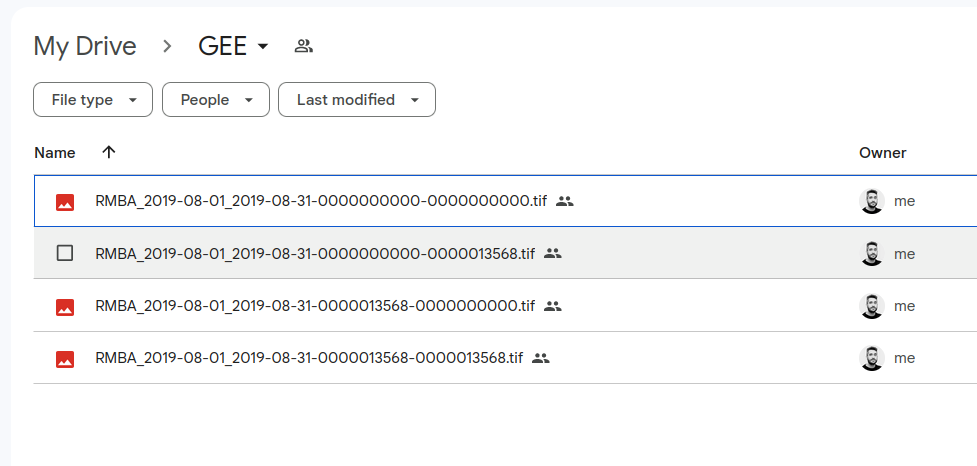